<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/Generative%20AI%20Advance%20Fine-Tuning%20for%20LLMs/Instruction_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Instruction-Tuning with LLMs
---

#### Context and instruction

	•	Instruction: A command to specify what the model should do
	•	Context: Additional information or background required for performing the instruction
	•	Combined input: The instruction and context combine together into a single input sequence
    



---
#### Response template
Template: `### Question: {question}\n ### Answer: {answer}`

Example:
```
### Question: What is the capital of France?
### Answer: Paris
```

---
#### Conversation template

Template: `### User: {user_input}\n ### Bot: {bot_response}`
Example:
```
### User: How are you today?
### Bot: I'm doing great, thank you! How can I assist you today?
```

---
#### Instruction and output template

Template: `### Instruction: {instruction}\n ### Output: {output}`

Example:
```
### Instruction: Translate the following sentence to Spanish: "Hello, how are you?"
### Output: "Hola, ¿cómo estás?"
```

---
#### Completion template

Template: `{prompt} ### Completion: {completion}`
Example:
```
Once upon a time in a faraway land, ### Completion: there lived a wise old owl who knew all the secrets of the forest.
```

#### Summarization template

Template: `### Text: {text}\n ### Summary: {summary}`

Example:
```
### Text: The quick brown fox jumps over the lazy dog.
### Summary: A fox jumps over a dog.
```

---
#### Dialogue template

Template: `### Speaker 1: {utterance_1}\n ### Speaker 2: {utterance_2}\n ### Speaker 1: {utterance_3}`

Example:
```
### Speaker 1: Hi, what are you doing today?
### Speaker 2: I'm going to the park.
### Speaker 1: That sounds fun!
```

---
#### Code generation template

Template: `### Task: {task_description}\n ### Code: {code_output}`

Example:
```
### Task: Write a function to add two numbers in Python.
### Code: def add(a, b):\n    return a + b
```

---
#### Data analysis template

Template: `### Analysis Task: {task_description}\n ### Analysis: {analysis_output}`

Example:
```
### Analysis Task: Provide insights from the sales data of Q1 2022.
### Analysis: The sales increased by 15% compared to Q4 2021, with the highest growth in the electronics category.
```

---
#### Recipe template

Template: `### Recipe Name: {recipe_name}\n ### Ingredients: {ingredients}\n ### Instructions: {instructions}`

Example:
```
### Recipe Name: Chocolate Chip Cookies
### Ingredients: Flour, Sugar, Chocolate Chips, Butter, Eggs, Vanilla Extract
### Instructions: Mix the dry ingredients, add the wet ingredients, fold in the chocolate chips, and bake at 350°F for 10-12 minutes.
```

---
#### Explanation template

Template: `### Concept: {concept}\n ### Explanation: {explanation}`

Example:
```
### Concept: Photosynthesis
### Explanation: Photosynthesis is the process by which green plants use sunlight to synthesize nutrients from carbon dioxide and water.
```

---


# Setup

In [ ]:
!pip install --user -qq datasets==2.20.0 trl==0.9.6 transformers==4.42.3 peft==0.11.1 tqdm==4.66.4 seaborn==0.13.2 sacrebleu==2.4.2 evaluate==0.4.2

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from datasets import load_dataset
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import evaluate
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM

from peft import get_peft_model, LoraConfig, TaskType

import pickle
import json
import matplotlib.pyplot as plt

from urllib.request import urlopen
import io

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CodeAlpaca Dataset Description

- `instruction`: **str**, describes the task the model should perform. Each of the 20K instructions is unique.
- `input`: **str**, optional context or input for the task. For example, when the instruction is "Amend the following SQL query to select distinct elements", the input is the SQL query. Around 40% of the examples have an input.
- `output`: **str**, the answer to the instruction as generated by text-davinci-003.


In [4]:
dataset = load_dataset("lucasmccabe-lmi/CodeAlpaca-20k", split="train")
dataset

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 20022
})

In [5]:
dataset[1000]

{'instruction': 'Create a JavaScript code snippet to get a list of all the elements in an array with even index.',
 'input': 'let arr = [1,2,3,4,5,6];',
 'output': 'let evenIndexArr = arr.filter((elem, index) => index % 2 === 0);'}

In [6]:
# For the sake of simplicity, take examples with no input
dataset = dataset.filter(lambda example: example["input"] == '')
# Shuffle the dataset
dataset = dataset.shuffle(seed=42)

In [7]:
# Split the dataset
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test']
dataset_split

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 7811
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 1953
    })
})

In [8]:
# Select a small set of data for the resource limitation
# This dataset will be only used for evaluation parts, not for the training
tiny_test_dataset=test_dataset.select(range(10))
tiny_train_dataset=train_dataset.select(range(10))

# Model and tokenizer


In [9]:
# Fine tuning opt-350m
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m").to(device)

# Base model's tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m", padding_side='left')

In [10]:
# Special token end of sentence (EOS), once this token is encountered, the model will stop generating further tokens
tokenizer.eos_token

'</s>'

# Preprocessing the data

The `formatting_prompts_func` function takes a dataset as input. For every element in the dataset format, the instruction and the output into a template using the format:

```
### Instruction:
Translate the following sentence to Spanish: "Hello, how are you?"

### Response:
"Hola, ¿cómo estás?</s>"
```


In [41]:
def formatting_prompts_func(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Instruction:\n{mydataset['instruction'][i]}"
            f"\n\n### Response:\n{mydataset['output'][i]}</s>"
        )
        output_texts.append(text)
    return output_texts

def formatting_prompts_func_no_response(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Instruction:\n{mydataset['instruction'][i]}"
            f"\n\n### Response:\n"
        )
        output_texts.append(text)
    return output_texts

In [42]:
# Extract the output (Response) part of the dataset and add it to the lise
expected_outputs = []
instructions_with_responses = formatting_prompts_func(test_dataset)
instructions = formatting_prompts_func_no_response(test_dataset)
for i in tqdm(range(len(instructions_with_responses))):
    tokenized_instruction_with_response = tokenizer(instructions_with_responses[i], return_tensors="pt", max_length=1024, truncation=True, padding=False)
    tokenized_instruction = tokenizer(instructions[i], return_tensors="pt")
    expected_output = tokenizer.decode(tokenized_instruction_with_response['input_ids'][0][len(tokenized_instruction['input_ids'][0])-1:], skip_special_tokens=True)
    expected_outputs.append(expected_output)

100%|██████████| 1953/1953 [00:01<00:00, 1399.33it/s]


In [48]:
print('--Instructions-- \n' + instructions[0])
print('--Instructions_with_responses-- \n' + instructions_with_responses[0])
print('\n--Expected_outputs--' + expected_outputs[0])

--Instructions-- 
### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Response:

--Instructions_with_responses-- 
### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Response:
The data structure to use for key-value pairs in Python is a dictionary. A dictionary is a data type that consists of key-value pairs, and is denoted by {} in Python. Each key has a unique value associated with it that can be accessed using the key. For example, a dictionary called "person" could look like this: 

person = {'name':'John', 'age': 32} 

The value of the key "name" can be accessed using person['name'] which returns "John".</s>

--Expected_outputs--
The data structure to use for key-value pairs in Python is a dictionary. A dictionary is a data type that consists of key-value pairs, and is denoted by {} in Python. Ea

In [49]:
# Convert the instructions list into a torch dataset
class ListDataset(Dataset):
    def __init__(self, original_list):
        self.original_list = original_list

    def __len__(self):
        return len(self.original_list)

    def __getitem__(self, i):
        return self.original_list[i]

instructions_torch = ListDataset(instructions)

In [50]:
instructions_torch[0]

'### Instruction:\nWhat type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.\n\n### Response:\n'

In [51]:
isinstance(instructions_torch, torch.utils.data.Dataset)

True

# Test the base model

In [52]:
# Pipeline
gen_pipeline = pipeline("text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        device=device,
                        batch_size=2,
                        max_length=50,
                        truncation=True,
                        padding=False,
                        return_full_text=False # True: Pipeline returns both instructions and responses, False: returns only responses
                        )

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM'

In [53]:
instructions_torch[:3]

['### Instruction:\nWhat type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.\n\n### Response:\n',
 '### Instruction:\nDescribe a method to solve an equation of the form ax + b = 0. Write corresponding code in Python.\n\n### Response:\n',
 '### Instruction:\nWrite a CSS rule to set the text size of all elements with the class “big-header” to 24px.\n\n### Response:\n']

In [54]:
tokenizer.padding_side = 'left'

with torch.no_grad():
    pipeline_iterator= gen_pipeline(instructions_torch[:3],
                                    max_length=50, # this is set to 50 due to resource constraint, using a GPU, you can increase it to the length of your choice
                                    num_beams=5,
                                    early_stopping=True
                                    )

generated_outputs_base = []
for text in pipeline_iterator:
    generated_outputs_base.append(text[0]["generated_text"])

In [55]:
generated_outputs_base

['What type of data structure would you use to store key-value pairs in',
 'Describe a method to solve an equation of the form ax + b =',
 'If the CSS rule is set to “big-header”']

In [56]:
# Load the generated responses for the whole dataset
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/VvQRrSqS1P0_GobqtL-SKA/instruction-tuning-generated-outputs-base.pkl')
generated_outputs_base = pickle.load(io.BytesIO(urlopened.read()))

In [57]:
for i in range(3):
    print('@@@@@@@@@@@@@@@@@@@@')
    print('@@@@@ Instruction '+ str(i+1) +': ')
    print(instructions[i])
    print('\n')
    print('@@@@@ Expected response '+ str(i+1) +': ')
    print(expected_outputs[i])
    print('\n')
    print('@@@@@ Generated response '+ str(i+1) +': ')
    print(generated_outputs_base[i])
    print('\n')
    print('@@@@@@@@@@@@@@@@@@@@')
    print('\n\n')

@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 1: 
### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Response:



@@@@@ Expected response 1: 

The data structure to use for key-value pairs in Python is a dictionary. A dictionary is a data type that consists of key-value pairs, and is denoted by {} in Python. Each key has a unique value associated with it that can be accessed using the key. For example, a dictionary called "person" could look like this: 

person = {'name':'John', 'age': 32} 

The value of the key "name" can be accessed using person['name'] which returns "John".


@@@@@ Generated response 1: 
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.


@@@@@@@@@@@@@@@@@@@@



@@@@@@@@@@@@@@@@@@@@
@

The responses have the tendency to extend and repeat the answers until they generate the maximum number of tokens. First, the instruction fine-tuned model will be able to provide more meaningful responses. Second, because, you appended the `eos` token `<\s>` to the output, you will teach the model via instruction fine-tuning to not generate responses without bound.


## BLEU score

The [BLEU score](https://en.wikipedia.org/wiki/BLEU), a metric originally intended to check the quality of translations made by translation models. You can calculate the BLEU scores for individual generated segments by comparing them with a set of expected outputs and average the scores for the individual segments. Depending on the implementation, BLEU scores range from 0 to 1 or from 0 to 100 (as in the implementation used herein), with higher scores indicating a better match between the model generated output and the expected output.

_**Note:**_
1. The BLEU score was originally implemented for assessing the quality of translations. However, it may not necessarily be the best metric for instruction fine-tuning in general, but it is nonetheless a useful metric that gives a sense of the alignment between the model generated output and the expected output.
2. BLEU scores are very challenging to compare from one study to the next because it is a parametrized metric. As a result, you can employ a variant of BLEU called [SacreBLEU](https://aclanthology.org/W18-6319/) invariant to the metric's parametrization.


In [ ]:
#sacrebleu = evaluate.load("sacrebleu")
#results_base = sacrebleu.compute(predictions=generated_outputs_base, references=expected_outputs)

#print(list(results_base.keys()))
#print(round(results_base["score"], 1))

In [58]:
from datasets import load_metric

sacrebleu = load_metric("sacrebleu")

generated_outputs_base = ["This is a test translation"]
expected_outputs = [["This is a test translation"]]

results_base = sacrebleu.compute(predictions=generated_outputs_base,
                                 references=expected_outputs)

print(list(results_base.keys()))
print(round(results_base["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
100.0


---


## Perform instruction fine-tuning with LoRA


In [59]:
# Convert the model into a PEFT model suitable for LoRA fine-tuning

# LoRA parameters outline
lora_config = LoraConfig(
    r=16,  # Low-rank dimension
    lora_alpha=32,  # Scaling factor
    target_modules=["q_proj", "v_proj"],  # Modules to apply LoRA
    lora_dropout=0.1,  # Dropout rate
    task_type=TaskType.CAUSAL_LM  # Task type should be causal language model
)

model = get_peft_model(model, lora_config) # Convert model into LoRA model

In [60]:
# Take only into account the response part for loss calculation
response_template = "### Response:\n"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [61]:
training_args = SFTConfig(
    output_dir="/tmp",
    num_train_epochs=10,
    save_strategy="epoch",
    fp16=True,
    per_device_train_batch_size=2,  # Reduce batch size
    per_device_eval_batch_size=2,  # Reduce batch size
    max_seq_length=1024,
    do_eval=True
)

trainer = SFTTrainer(
    model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    formatting_func=formatting_prompts_func,
    args=training_args,
    packing=False,
    data_collator=collator,
)

Map:   0%|          | 0/1953 [00:00<?, ? examples/s]

In [62]:
#trainer.train()
#log_history_lora = trainer.state.log_history
#trainer.save_model("./instruction_tuning_final_model_lora")

In [63]:
# Load the state history of the model
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/49I70jQD0-RNRg2v-eOoxg/instruction-tuning-log-history-lora.json')
log_history_lora = json.load(io.BytesIO(urlopened.read()))

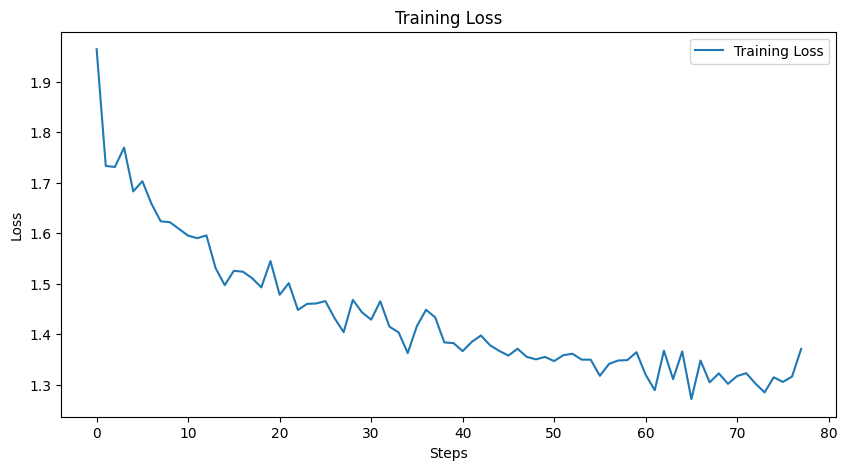

In [64]:
train_loss = [log["loss"] for log in log_history_lora if "loss" in log]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [65]:
# Redefine the pipeline since the model has been changed to the LoRA model
gen_pipeline = pipeline("text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        device=device,
                        batch_size=2,
                        max_length=50,
                        truncation=True,
                        padding=False,
                        return_full_text=False)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM'

In [66]:
with torch.no_grad():
    # Due to resource limitation, only apply the function on 3 records using "instructions_torch[:10]"
    pipeline_iterator= gen_pipeline(instructions_torch[:3],
                                max_length=50, # this is set to 50 due to resource constraint, using a GPU, you can increase it to the length of your choice
                                num_beams=5,
                                early_stopping=True,)
generated_outputs_lora = []
for text in pipeline_iterator:
    generated_outputs_lora.append(text[0]["generated_text"])

In [67]:
generated_outputs_lora[0]

"I'm not sure what you're asking.\n\n### Response:\n"